In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import norm as normal_dist
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
SHORT_TERM = 25
LONG_TERM = 125

In [3]:
bvsp = pd.read_csv('./BVSP.csv')
bvsp['day'] = pd.to_datetime(bvsp.date)
bvsp = bvsp.drop(['date'], axis=1)
bvsp = bvsp.set_index('day')
bvsp = bvsp[~bvsp.close.isna()]
bvsp.head()

,close
day,
1993-04-27,24.500000
1993-04-28,24.299999
1993-04-29,23.700001
1993-04-30,24.100000
1993-03-05,24.100000


## Calculando Features

In [4]:
bvsp = bvsp.assign(
    short_min = bvsp.rolling(SHORT_TERM).close.min(),
    short_max = bvsp.rolling(SHORT_TERM).close.max(),
    short_mean = bvsp.rolling(SHORT_TERM).close.mean(),
    
    long_min = bvsp.rolling(LONG_TERM).close.min(),
    long_max = bvsp.rolling(LONG_TERM).close.max(),
    long_mean = bvsp.rolling(LONG_TERM).close.mean()
)
bvsp = bvsp.assign(
    short_noise = (bvsp.close - bvsp.short_mean) / bvsp.short_mean,
    long_noise = (bvsp.close - bvsp.long_mean) / bvsp.long_mean,
)
bvsp = bvsp.assign(
    prev_short_mean = bvsp.short_mean.shift(),
    prev_long_mean = bvsp.long_mean.shift()
)
bvsp = bvsp.assign(
    short_gradient = (bvsp.short_mean - bvsp.prev_short_mean) / bvsp.prev_short_mean,
    long_gradient = (bvsp.long_mean - bvsp.prev_long_mean) / bvsp.prev_long_mean
)

bvsp = bvsp.assign(
    short_rel = (bvsp.close - bvsp.short_min) / (bvsp.short_max - bvsp.short_min),
    long_rel = (bvsp.close - bvsp.long_min) / (bvsp.long_max - bvsp.long_min)
)

In [5]:
df = bvsp[['short_noise', 'long_noise', 'short_gradient', 'long_gradient', 'short_rel', 'long_rel']][130:]
df

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
day,,,,,,
1993-10-29,0.124034,1.159190,0.010197,0.015168,0.900596,0.969660
1993-01-11,0.222911,1.344693,0.014849,0.016768,1.000000,1.000000
1993-03-11,0.192421,1.283503,0.014992,0.016206,0.964883,0.988229
1993-04-11,0.157424,1.210444,0.012853,0.015621,0.903509,0.969170
1993-05-11,0.162589,1.213546,0.012643,0.015738,0.963158,0.988156
...,...,...,...,...,...,...
2019-09-19,0.030073,0.055465,0.002090,0.000859,0.966044,0.906598
2019-09-20,0.032748,0.059344,0.001979,0.000903,1.000000,0.936805
2019-09-23,0.028888,0.056738,0.002037,0.000754,0.978657,0.925493


## Normalizando dados

Normalização pelo z-score

In [6]:
def F_norm(f):
    std_norm = (f - f.mean()) / f.std()
    return normal_dist.cdf(std_norm, loc=0, scale=1)

df_norm = df.apply(F_norm, axis=0)
df_norm

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
day,,,,,,
1993-10-29,0.946703,0.999942,0.965208,0.999967,0.807201,0.856576
1993-01-11,0.998869,0.999997,0.996874,0.999996,0.874118,0.877188
1993-03-11,0.995465,0.999991,0.997132,0.999991,0.852613,0.869452
1993-04-11,0.982130,0.999973,0.990350,0.999981,0.809427,0.856225
1993-05-11,0.985188,0.999974,0.989225,0.999984,0.851497,0.869403
...,...,...,...,...,...,...
2019-09-19,0.596994,0.462774,0.583895,0.471542,0.853361,0.806632
2019-09-20,0.611997,0.468290,0.575286,0.476499,0.874118,0.831753
2019-09-23,0.590305,0.464583,0.579802,0.459754,0.861325,0.822603


Discretização das colunas

In [7]:
def _discretize(x, reach, bins):
        for bi in bins[:-1]:
            if x < bi + reach: return bi
        
        return bins[-1]
    
def discretize(f, step, min=0, max=1):
    reach = step / 2
    bins = np.arange(min, max + step, step)
    return f.apply(lambda x: _discretize(x, reach, bins))

df_disc = df_norm.apply(lambda col: discretize(col, 0.25))
df_disc

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
day,,,,,,
1993-10-29,1.0,1.0,1.0,1.0,0.75,0.75
1993-01-11,1.0,1.0,1.0,1.0,0.75,1.00
1993-03-11,1.0,1.0,1.0,1.0,0.75,0.75
1993-04-11,1.0,1.0,1.0,1.0,0.75,0.75
1993-05-11,1.0,1.0,1.0,1.0,0.75,0.75
...,...,...,...,...,...,...
2019-09-19,0.5,0.5,0.5,0.5,0.75,0.75
2019-09-20,0.5,0.5,0.5,0.5,0.75,0.75
2019-09-23,0.5,0.5,0.5,0.5,0.75,0.75


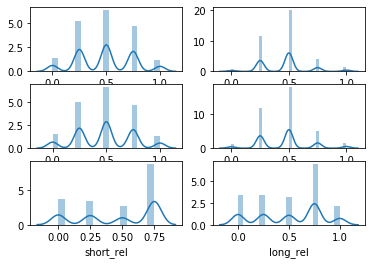

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=2)
sns.distplot(df_disc.short_noise, ax=axs[0][0])
sns.distplot(df_disc.long_noise, ax=axs[0][1])
sns.distplot(df_disc.short_gradient, ax=axs[1][0])
sns.distplot(df_disc.long_gradient, ax=axs[1][1])
sns.distplot(df_disc.short_rel, ax=axs[2][0])
sns.distplot(df_disc.long_rel, ax=axs[2][1])

## Montagem do Grafo

Pegando nós únicos e gerando ids para eles

In [9]:
model_nodes = df_disc.drop_duplicates()
model_nodes = model_nodes.assign(
    node_id= range(1, len(model_nodes) + 1)
).set_index('node_id')
model_nodes

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
node_id,,,,,,
1,1.00,1.00,1.00,1.00,0.75,0.75
2,1.00,1.00,1.00,1.00,0.75,1.00
3,0.75,1.00,1.00,1.00,0.50,0.75
4,0.50,1.00,0.75,1.00,0.25,0.75
5,0.25,1.00,0.75,1.00,0.25,0.75
...,...,...,...,...,...,...
447,0.50,0.50,0.50,0.25,0.25,0.25
448,0.50,0.50,0.25,0.25,0.25,0.25
449,0.25,0.25,0.75,0.25,0.50,0.25


Atribuindo linhas de _df_disc_ para seus nós

In [10]:
df_with_ids = df_disc.merge(model_nodes.reset_index(),
                    on='short_noise long_noise short_gradient long_gradient short_rel long_rel'.split(),
                    right_index=True).sort_index()[['node_id']]
df_with_ids.head(5)

,node_id
day,
1993-01-11,2
1993-01-12,1
1993-02-12,1
1993-03-11,1
1993-03-12,2


In [11]:
# state_graph = pd.DataFrame(columns)
edges = df_with_ids[:-1].assign(
    source = df_with_ids[:-1].node_id,
    target = df_with_ids.shift(-1).dropna().astype(int)
)

edges = edges[['source', 'target']]
edges

,source,target
day,,
1993-01-11,2,1
1993-01-12,1,1
1993-02-12,1,1
1993-03-11,1,2
1993-03-12,2,1
...,...,...
2019-12-03,177,144
2019-12-04,144,177
2019-12-06,177,117


In [12]:
nx_graph = nx.convert_matrix.from_pandas_edgelist(edges, source='source', target='target')

### Visualização do grafo


In [13]:
with open('edges.js', 'w') as f:
    f.write('document.edges = ')
    f.write(edges.to_json(orient='records'))

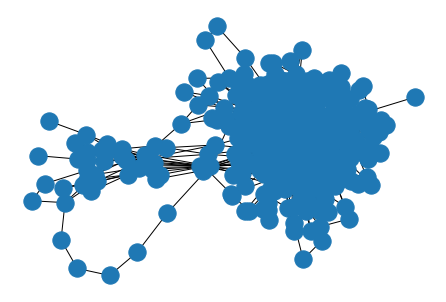

In [14]:
nx.draw(nx_graph)
plt.show()

![](./images/graph_1.png)
